# Progetto Intelligenza Artificiale II - A.A. 2025/26
## Studio Clinico sulla Progressione dell'HIV (Dataset ACTG 175)

**Componenti del gruppo:**
* Giordano Zaccardi (2131200)
* Laura Dominioni (Matricola)

---

### Abstract
L'obiettivo di questo progetto è sviluppare un modello predittivo capace di identificare la **progressione della malattia** in pazienti affetti da HIV. Abbiamo utilizzato dati demografici e clinici per addestrare diversi algoritmi di classificazione, confrontando approcci *baseline* con tecniche di *ensemble learning* ottimizzate.

### 1. Acquisizione del Dataset
Abbiamo utilizzato la libreria `ucimlrepo` per importare i dati. Il dataset include:
1. **Dati demografici:** Età, peso, sesso.
2. **Parametri clinici:** Conteggio cellule CD4 e CD8.
3. **Target (`cid`):** Variabile binaria che indica la progressione della malattia.

In [1]:
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo

# fetch dataset
aids_clinical_trials_group_study_175 = fetch_ucirepo(id=890)

# data (as pandas dataframes)
X = aids_clinical_trials_group_study_175.data.features
y = aids_clinical_trials_group_study_175.data.targets

# metadata
print(aids_clinical_trials_group_study_175.metadata)

# variable information
print(aids_clinical_trials_group_study_175.variables)


{'uci_id': 890, 'name': 'AIDS Clinical Trials Group Study 175', 'repository_url': 'https://archive.ics.uci.edu/dataset/890/aids+clinical+trials+group+study+175', 'data_url': 'https://archive.ics.uci.edu/static/public/890/data.csv', 'abstract': 'The AIDS Clinical Trials Group Study 175 Dataset contains healthcare statistics and categorical information about patients who have been diagnosed with AIDS. This dataset was initially published in 1996. The prediction task is to predict whether or not each patient died within a certain window of time or not. ', 'area': 'Health and Medicine', 'tasks': ['Classification', 'Regression'], 'characteristics': ['Tabular', 'Multivariate'], 'num_instances': 2139, 'num_features': 23, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age', 'Sexual Orientation', 'Race', 'Gender'], 'target_col': ['cid'], 'index_col': ['pidnum'], 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1996, 'last_updated': 'Fri Nov 

In [2]:
import pandas as pd

# Uniamo X e y in un unico DataFrame chiamato 'Dati'
Dati = pd.concat([X, y], axis=1)

# Verifichiamo che tutto sia andato bene vedendo le prime 5 righe
Dati.head()

,time,trt,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,...,str2,strat,symptom,treat,offtrt,cd40,cd420,cd80,cd820,cid
0,948,2,48,89.8128,0,0,0,100,0,0,...,0,1,0,1,0,422,477,566,324,0
1,1002,3,61,49.4424,0,0,0,90,0,1,...,1,3,0,1,0,162,218,392,564,1
2,961,3,45,88.4520,0,1,1,90,0,1,...,1,3,0,1,1,326,274,2063,1893,0
3,1166,3,47,85.2768,0,1,0,100,0,1,...,1,3,0,1,0,287,394,1590,966,0
4,1090,0,43,66.6792,0,1,0,100,0,1,...,1,3,0,0,0,504,353,870,782,0


In [4]:
# Controlliamo quanti valori mancano per ogni colonna
print(Dati.isnull().sum())

time       0
trt        0
age        0
wtkg       0
hemo       0
homo       0
drugs      0
karnof     0
oprior     0
z30        0
zprior     0
preanti    0
race       0
gender     0
str2       0
strat      0
symptom    0
treat      0
offtrt     0
cd40       0
cd420      0
cd80       0
cd820      0
cid        0
dtype: int64


### 2. Analisi Esplorativa dei Dati (EDA)
In questa sezione abbiamo analizzato la struttura del dataset per individuare:
* **Distribuzione del target:** Verifica dello sbilanciamento delle classi.
* **Correlazioni:** Heatmap e Pairplot per identificare relazioni tra parametri clinici.
* **Outlier:** Identificazione di valori anomali tramite un'analisi statistica descrittiva.

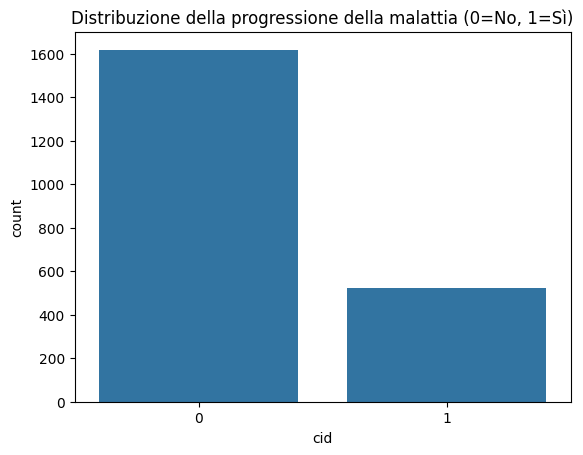

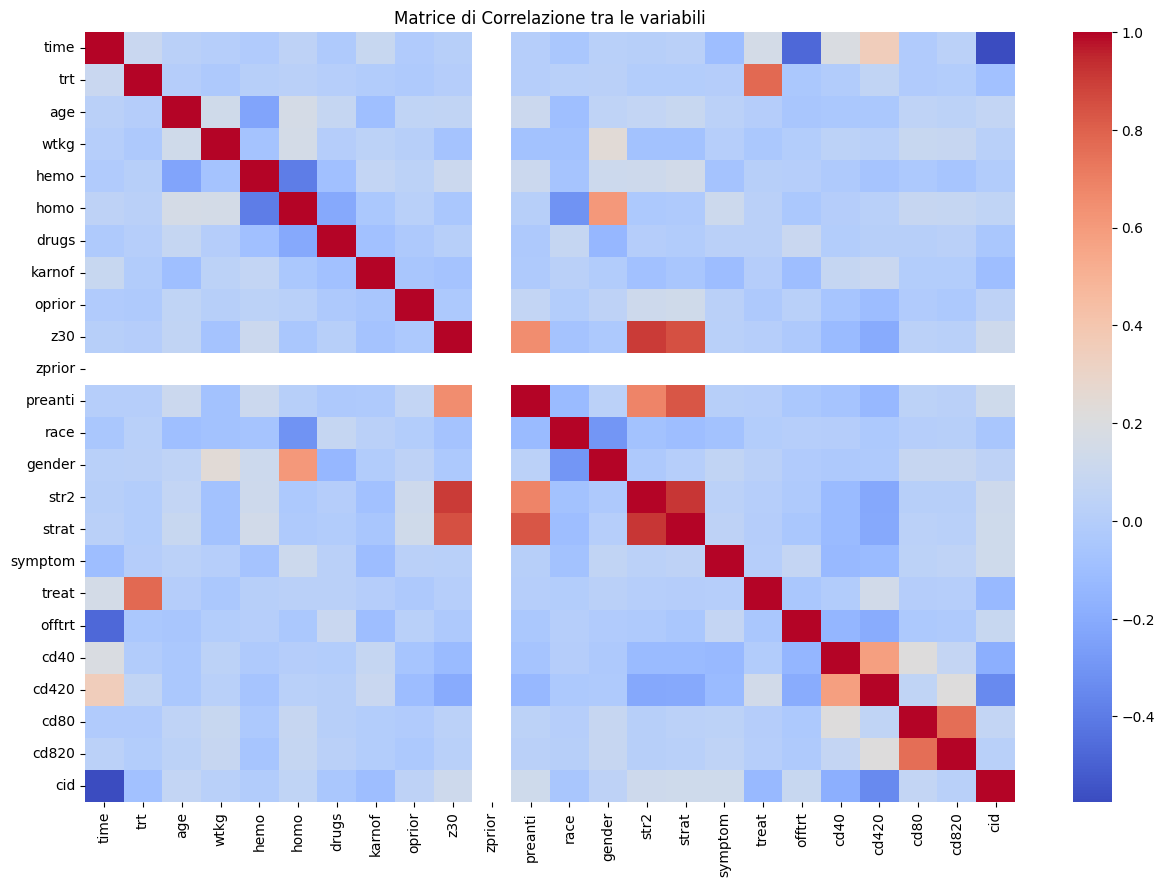

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Vediamo quanti pazienti hanno avuto la progressione (Target)
sns.countplot(x='cid', data=Dati)
plt.title('Distribuzione della progressione della malattia (0=No, 1=Sì)')
plt.show()

# Correlazione tra le variabili (Mappa di calore)
plt.figure(figsize=(15, 10))
sns.heatmap(Dati.corr(), annot=False, cmap='coolwarm')
plt.title('Matrice di Correlazione tra le variabili')
plt.show()

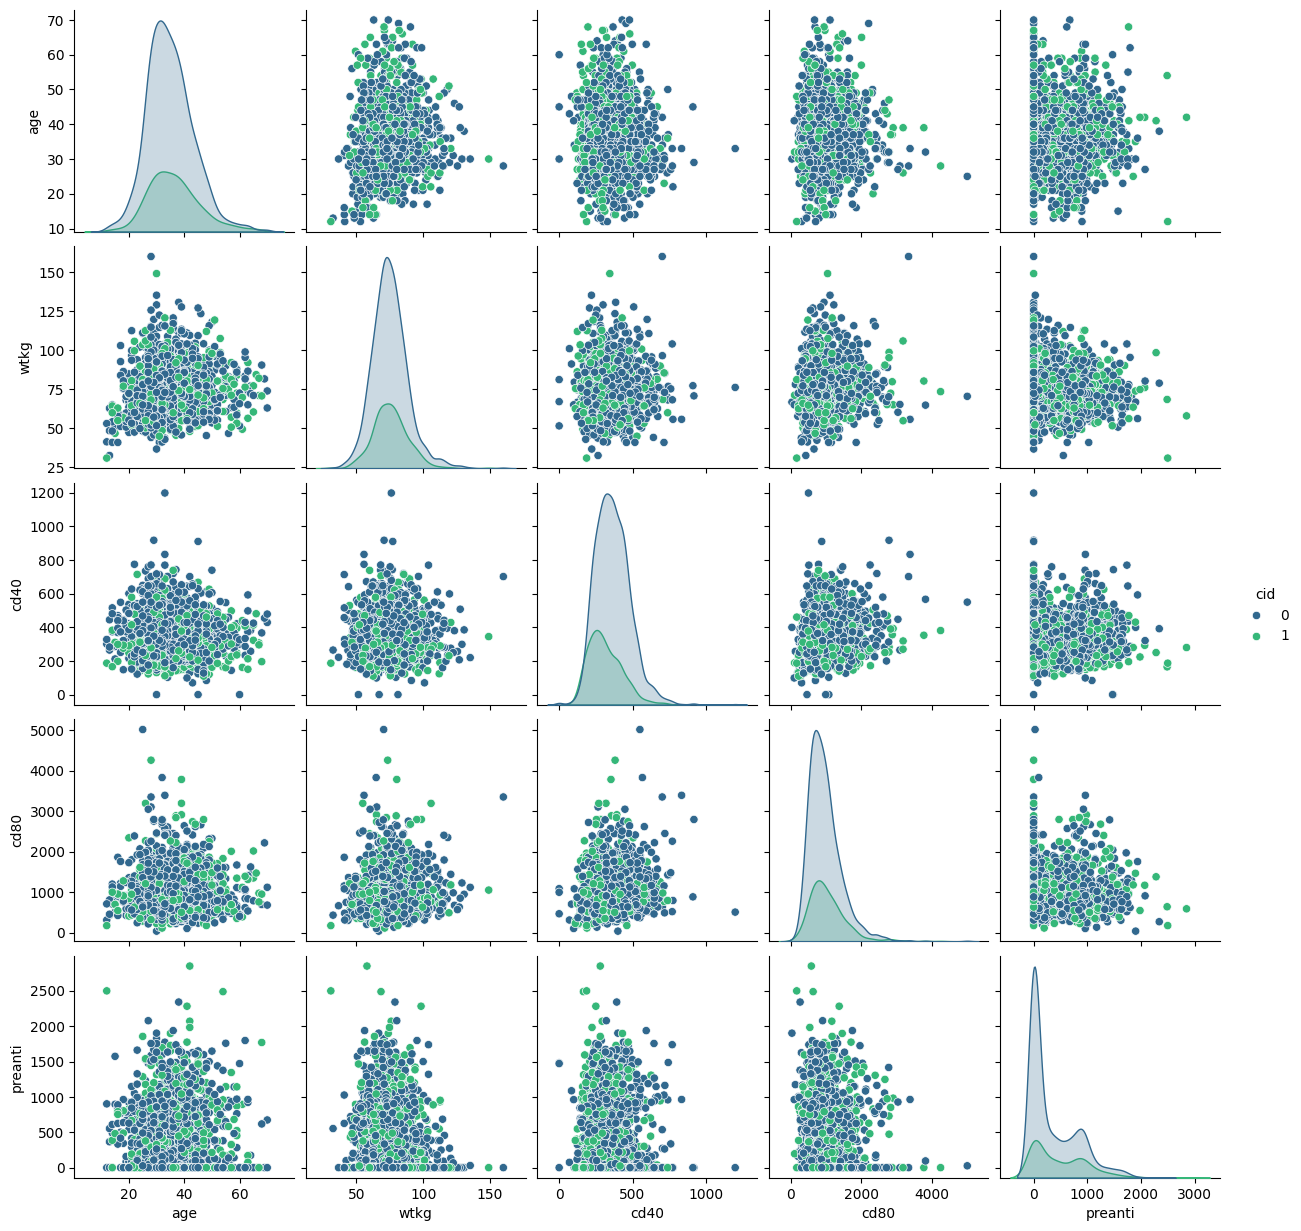

In [6]:
# Selezioniamo solo alcune colonne per non appesantire il grafico
Feature_interessanti = ['age', 'wtkg', 'cd40', 'cd80', 'preanti', 'cid']

# Creiamo il Pair Plot
# 'hue' colora i punti in base alla progressione della malattia
sns.pairplot(Dati[Feature_interessanti], hue='cid', palette='viridis', diag_kind='kde')
plt.show()

### 3. Preprocessing e Validazione
Per garantire l'integrità del modello, abbiamo applicato i seguenti passaggi di pulizia:

1. **Splitting:** Divisione in Training (80%) e Test set (20%) con stratificazione.
2. **Scaling:** Applicazione dello `StandardScaler` (Z-score) per normalizzare le variabili numeriche.  
> **Nota bene:** Le feature riguardanti i dati post-trattamento (es. CD4 a 20 settimane) sono state rimosse per evitare il *data leakage*, simulando una reale prima visita medica.

In [7]:
from sklearn.model_selection import train_test_split

# Pulizia: Teniamo solo le caratteristiche che un medico conosce
# al momento della prima visita (togliamo cid, cd420, cd820 e zprior)
colonne_da_escludere = ['cid', 'cd420', 'cd820', 'zprior']
X = Dati.drop(columns=colonne_da_escludere)
y = Dati['cid']

# 2. SPLIT: Creiamo il Train (80%) e il Test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Dataset diviso - Train: {len(X_train)} righe, Test: {len(X_test)} righe.")

Dataset diviso - Train: 1711 righe, Test: 428 righe.


In [8]:
from sklearn.preprocessing import StandardScaler

# Inizializziamo lo scaler (che calcola lo Z-score)
z_scaler = StandardScaler()

# Calcola media e deviazione standard solo sul Train Set
z_scaler.fit(X_train)

# Applica la formula dello Z-score a entrambi i set
X_train_z = z_scaler.transform(X_train)
X_test_z = z_scaler.transform(X_test)

print("Standardizzazione Z-score completata")

Standardizzazione Z-score completata


### 4. SVILUPPO DEI MODELLI
Abbiamo implementato una pipeline di test che comprende:
* **Modelli Baseline:** Regressione Logistica e k-NN.
* **Modelli Ensemble:** Random Forest e XGBoost.



### 4.1 Regressione Logistica

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# 1. Creiamo il modello
modello_LR = LogisticRegression(class_weight='balanced', random_state=42)

# 2. Fase di addestramento
modello_LR.fit(X_train_z, y_train)

# 3. Fase di predizione: facciamo l'esame sul Test Set
y_pred = modello_LR.predict(X_test_z)

# 4. Risultati: stampiamo le metriche
print("Risultati del Modello")
print(classification_report(y_test, y_pred))

Risultati del Modello
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       324
           1       0.67      0.77      0.71       104

    accuracy                           0.85       428
   macro avg       0.79      0.82      0.81       428
weighted avg       0.86      0.85      0.85       428



#### 4.2 K-Nearest Neighbors

In [10]:
from sklearn.neighbors import KNeighborsClassifier

# Proviamo il K-NN con i pesi per gestire meglio la sovrapposizione
knn_weighted = KNeighborsClassifier(n_neighbors=7, weights='distance')

knn_weighted.fit(X_train_z, y_train)
y_pred_knn = knn_weighted.predict(X_test_z)

print("Risultati K-NN (Weighted)")
print(classification_report(y_test, y_pred_knn))

Risultati K-NN (Weighted)
              precision    recall  f1-score   support

           0       0.84      0.98      0.90       324
           1       0.86      0.42      0.57       104

    accuracy                           0.84       428
   macro avg       0.85      0.70      0.74       428
weighted avg       0.85      0.84      0.82       428



#### 4.3 Random Forest

In [11]:
from sklearn.ensemble import RandomForestClassifier

# 1. Creiamo la Random Forest (usiamo 100 alberi)
rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

# 2. Fase di addestramento
rf.fit(X_train_z, y_train)

# 3. Fase di predizione
y_pred_rf = rf.predict(X_test_z)

# 4. Risultati
print("Risultati Random Forest")
print(classification_report(y_test, y_pred_rf))

Risultati Random Forest
              precision    recall  f1-score   support

           0       0.90      0.94      0.92       324
           1       0.79      0.66      0.72       104

    accuracy                           0.88       428
   macro avg       0.85      0.80      0.82       428
weighted avg       0.87      0.88      0.87       428



#### 4.4 Ottimizzazione (Hyperparameter Tuning)
Per la **Random Forest**, abbiamo eseguito una `GridSearchCV` testando i seguenti parametri:
* `n_estimators`
* `max_depth`
* `min_samples_split`

La stabilità è stata verificata tramite una **K-Fold Cross-Validation** ($K=5$).

In [12]:
from sklearn.model_selection import GridSearchCV, cross_val_score

# TUNING (Ricerca parametri migliori)
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

# Creiamo il ricercatore
grid_search_rf = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=42),
                             param_grid_rf, cv=3, scoring='f1')
grid_search_rf.fit(X_train_z, y_train)

# Salviamo il modello in una nuova variabile per confrontarlo con 'rf'
rf_tuned = grid_search_rf.best_estimator_

print(f"Migliori parametri trovati: {grid_search_rf.best_params_}")

# CROSS-VALIDATION
cv_scores = cross_val_score(rf_tuned, X_train_z, y_train, cv=5)
print(f"Accuratezza media Cross-Validation: {cv_scores.mean():.4f}")

Migliori parametri trovati: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Accuratezza media Cross-Validation: 0.8825


#### 4.5 XG-BOOST


In [13]:
from xgboost import XGBClassifier

# 1. Creiamo il modello
# scale_pos_weight aiuta a gestire lo sbilanciamento (è il rapporto tra sani e malati)
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, scale_pos_weight=3, random_state=42)

# 2. Fase di addestramento
xgb_model.fit(X_train_z, y_train)

# 3. Fase di predizione
y_pred_xgb = xgb_model.predict(X_test_z)

print("Risultati XGBoost")
print(classification_report(y_test, y_pred_xgb))

Risultati XGBoost
              precision    recall  f1-score   support

           0       0.93      0.92      0.92       324
           1       0.75      0.77      0.76       104

    accuracy                           0.88       428
   macro avg       0.84      0.84      0.84       428
weighted avg       0.88      0.88      0.88       428



### 5. Valutazione e Conclusioni Finali
Il confronto finale si basa sulla **Analisi dei Residui** tra la Random Forest e lo XGBoost, per valutare la calibrazione delle probabilità predette.

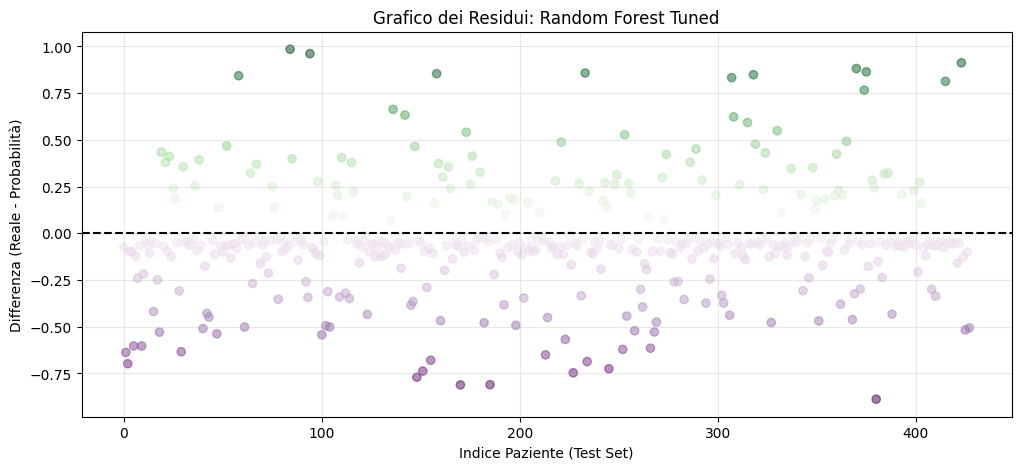

In [14]:
# Calcoliamo le probabilità per la classe 1 usando il modello ottimizzato
y_probs_rf_tuned = rf_tuned.predict_proba(X_test_z)[:, 1]

# Calcolo del residuo
residui_rf_tuned = y_test - y_probs_rf_tuned

plt.figure(figsize=(12, 5))
plt.scatter(range(len(residui_rf_tuned)), residui_rf_tuned, alpha=0.5, c=residui_rf_tuned, cmap='PRGn')
plt.axhline(0, color='black', linestyle='--')
plt.title('Grafico dei Residui: Random Forest Tuned')
plt.ylabel('Differenza (Reale - Probabilità)')
plt.xlabel('Indice Paziente (Test Set)')
plt.grid(alpha=0.3)
plt.show()

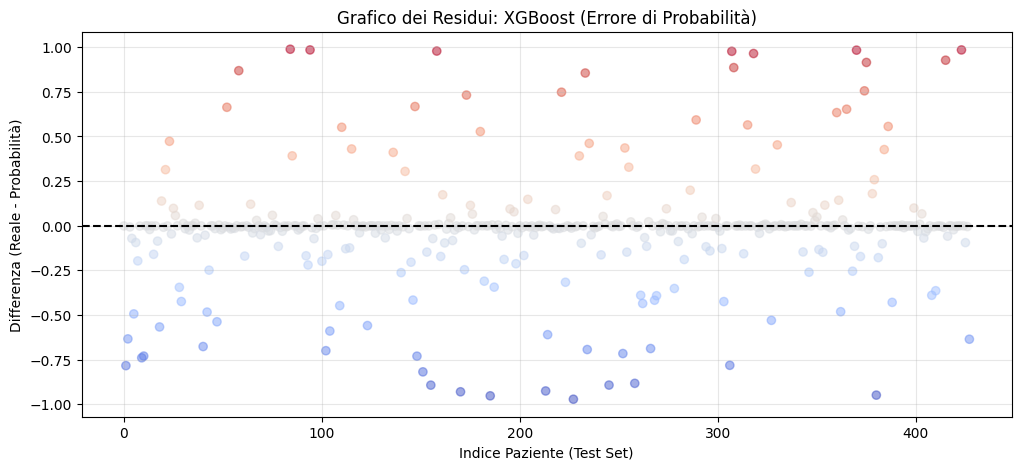

In [15]:
# Calcoliamo le probabilità per la classe 1
y_probs_xgb = xgb_model.predict_proba(X_test_z)[:, 1]

# Calcolo del residuo
residui_xgb = y_test - y_probs_xgb

plt.figure(figsize=(12, 5))
plt.scatter(range(len(residui_xgb)), residui_xgb, alpha=0.5, c=residui_xgb, cmap='coolwarm')
plt.axhline(0, color='black', linestyle='--')
plt.title('Grafico dei Residui: XGBoost (Errore di Probabilità)')
plt.ylabel('Differenza (Reale - Probabilità)')
plt.xlabel('Indice Paziente (Test Set)')
plt.grid(alpha=0.3)
plt.show()


# 6. Conclusioni

Al termine della sperimentazione, abbiamo confrontato quattro diversi approcci di classificazione per predire la progressione dell'HIV.

### Analisi delle performance:
* **XGBoost** si è dimostrato il modello più performante con un **F1-Score di 0.76** sulla classe critica e un'accuratezza globale dell'**88%**.
* La **Regressione Logistica** ha mostrato una notevole capacità di "recupero" (Recall 0.77), confermandosi un'ottima baseline statistica, sebbene meno precisa dei modelli ensemble.
* Il **k-NN** è risultato il modello meno adatto al contesto clinico a causa di una Recall troppo bassa (0.42), che porterebbe a ignorare molti pazienti effettivamente a rischio.
